# Tarea KMeans y Shap
## Arantza Gomez Haro Gamboa

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from xgboost import plot_importance
import shap 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve

In [26]:
def calibracion_multiple(modelos, y, bins):
    for nombre, predicciones in modelos.items():
        df_calibracion = pd.DataFrame({
            'predicciones': predicciones,
            'y': y
        })
        
        df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop') + 1
        grouped = df_calibracion.groupby('bins').mean()
        
        plt.figure()
    
        plt.plot(grouped.predicciones, grouped.y, label=f"{nombre} (Modelo)", marker="o", color="rosybrown")
        plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o", color="cornflowerblue")
        
        plt.grid()
        plt.legend()
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.title(f"Calibración para {nombre}")

### **Datos**

In [27]:
df = pd.read_csv('titanic.csv')
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
df = pd.get_dummies(df)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,1,38.0,1,0,71.2833,True,False,True,False,False
2,1,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,1,35.0,1,0,53.1000,True,False,False,False,True
4,0,3,35.0,0,0,8.0500,False,True,False,False,True


In [28]:
target = 'Survived'
y = df[target]
X = df.copy()
X = X.drop(target, axis = 1)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,38.0,1,0,71.2833,True,False,True,False,False
2,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,35.0,1,0,53.1000,True,False,False,False,True
4,3,35.0,0,0,8.0500,False,True,False,False,True


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **XGBoost**

In [30]:
model = XGBClassifier(
    n_estimators = 100_000,
    max_depth = 5,
    learning_rate = 0.1,
    reg_lambda = 0.1,
    subsample = 0.5,
    col_sample_by_tree = 0.8,
    tree_method = 'hist',
    early_stopping_rounds = 40,
    eval_metric = "auc"
)

model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 100)

[0]	validation_0-auc:0.87455	validation_1-auc:0.81609
[100]	validation_0-auc:0.97796	validation_1-auc:0.88044
[122]	validation_0-auc:0.98321	validation_1-auc:0.88211


c:\Users\arant\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [00:15:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "col_sample_by_tree" } are not used.

  self.starting_round = model.num_boosted_rounds()


XGBClassifier(base_score=None, booster=None, callbacks=None,
              col_sample_by_tree=0.8, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=40, enable_categorical=False,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100000, n_jobs=None, ...)

#### *AUC:*

In [31]:
predicciones_xg = model.predict_proba(X_test)[:,1]
roc_auc_score(y_score=predicciones_xg, y_true=y_test)

0.883912483912484

#### *Gráfica de Calibración:*

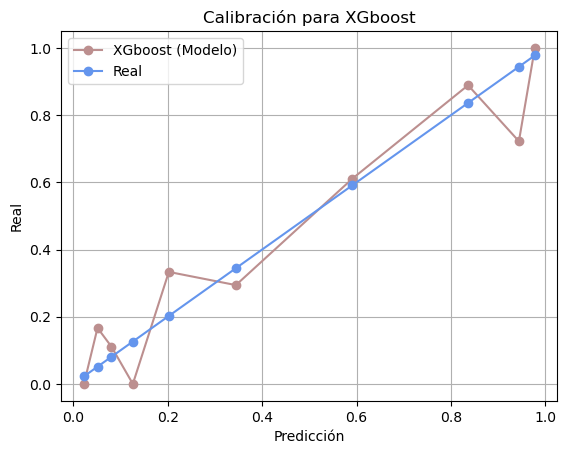

In [32]:
modelo = {
    'XGboost': predicciones_xg,
}

calibracion_multiple(modelo, y_test, bins=10)

##### *Histograma:*

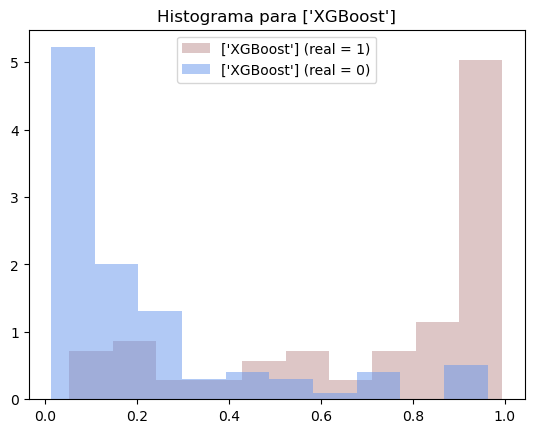

In [33]:
histograma = pd.DataFrame({
    'real': y_test,
    'XGBoost': predicciones_xg,
})

real1 = histograma[histograma['real'] == 1]
real0 = histograma[histograma['real'] == 0]

modelo = ['XGBoost']

plt.hist(real1[modelo], density=True, alpha=0.5, bins=10, color='rosybrown', label=f'{modelo} (real = 1)')
plt.hist(real0[modelo], density=True, alpha=0.5, bins=10, color='cornflowerblue', label=f'{modelo} (real = 0)')
plt.title(f'Histograma para {modelo}')
plt.legend()
plt.show()

##### *Curva ROC:*

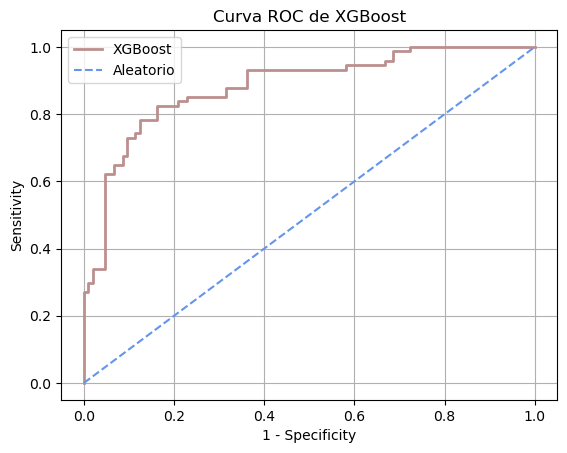

In [34]:
resultados = [predicciones_xg]

for i, modelo in enumerate(modelo):
    predicciones = resultados[i]
    fpr, tpr, _ = roc_curve(y_true=y_test, y_score=predicciones) 
    plt.plot(fpr, tpr, label=f'{modelo}', color='rosybrown', lw=2)
    plt.plot([0, 1], [0, 1], color='cornflowerblue', linestyle='--', lw=1.5, label='Aleatorio')
    plt.title(f'Curva ROC de {modelo}')
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.legend()
    plt.grid(True)
    plt.show()

#### *Feature Importance:*

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

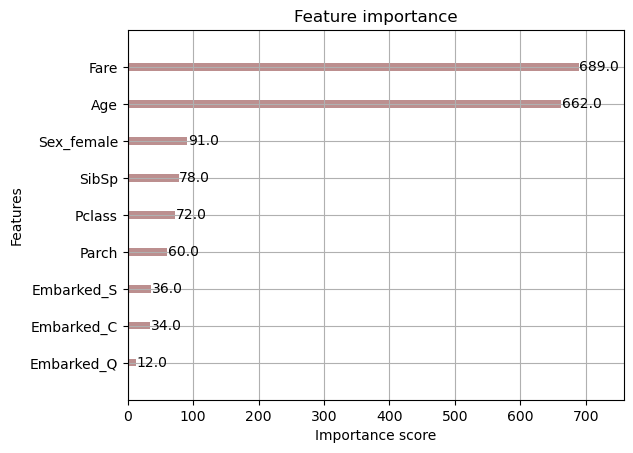

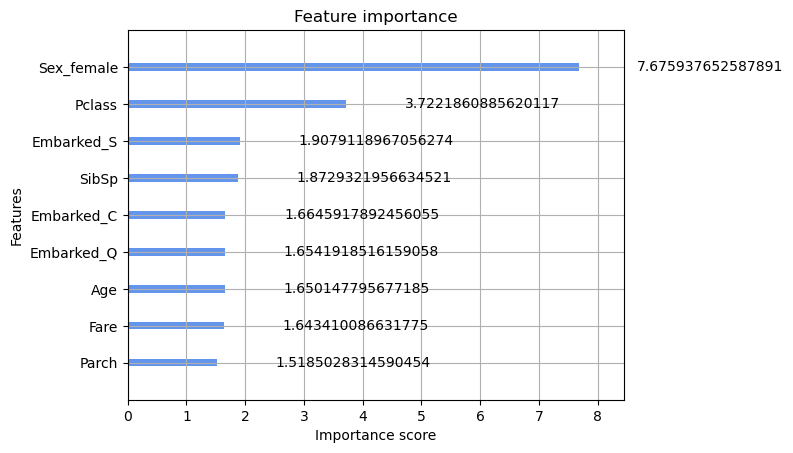

In [35]:
plot_importance(model, max_num_features=10, importance_type="weight", color = 'rosybrown')
plot_importance(model, max_num_features=10, importance_type="gain", color = 'cornflowerblue')

##### *Análisis:*

- Tras realizar el modelo de XGBoost, se obtuvo un valor de AUC Score de 0.8839. Este número nos indica una buena capacidad, por parte del modelo, de distinguir entre clases. Además, al momento de analizar la gráfica de calibración, se puede apreciar el buen ajuste que tiene este modelo en comparación con los datos reales. También, se puede ver en el histograma que el modelo cuenta con una buena predicción de clases. 

- En cuestión del feature importance, cuando se analiza el tipo "weight", se puede ver que las variables que se utilizan con mayor frecuencia son **Fare** y **Age**. Por otro lado, en cuestión del tipo "gain", las variables que logran reducir más la varianza son **Sex Female** y **Pclass**. 

### **Shap Values para una Predicción**

In [36]:
len(X_test)

179

In [37]:
X_shap = X_test.sample(175, random_state=42)

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_shap)

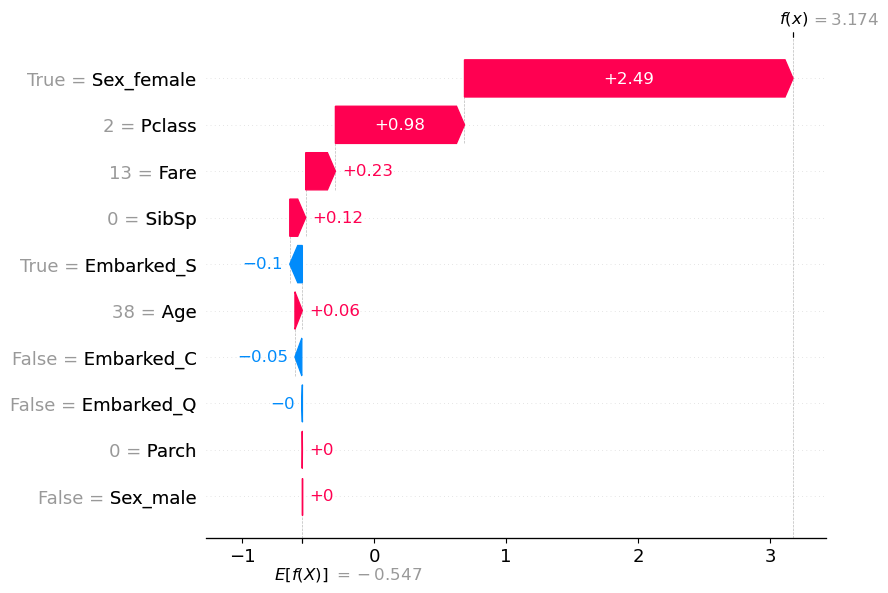

In [38]:
shap.initjs()

shap.plots.waterfall(shap.Explanation(
    values = shap_values[0],
    base_values = explainer.expected_value,
    data = X_shap.iloc[0],
    feature_names = X_shap.keys()
))


##### *Análisis:*

- Considerando esta predicción en específico, existe una alta probabilidad de que esta persona haya sobrevivido. Esto es debido a que los Shap values nos indican que esta persona es una mujer de pclass 2, características que contribuyen altamente al aumento en la probabilidad de sobrevivir. Dicho esto, algunas características que restan un poco a la predicción son Embarked_S y Embarked_C, sin embargo, el efecto de estas variables es mínima a comparación de las que tienen un peso positivo. Esto nos lleva a que la persona tenga una alta probabilidad de haber sobrevivido. 

### **Shap Values Generales**

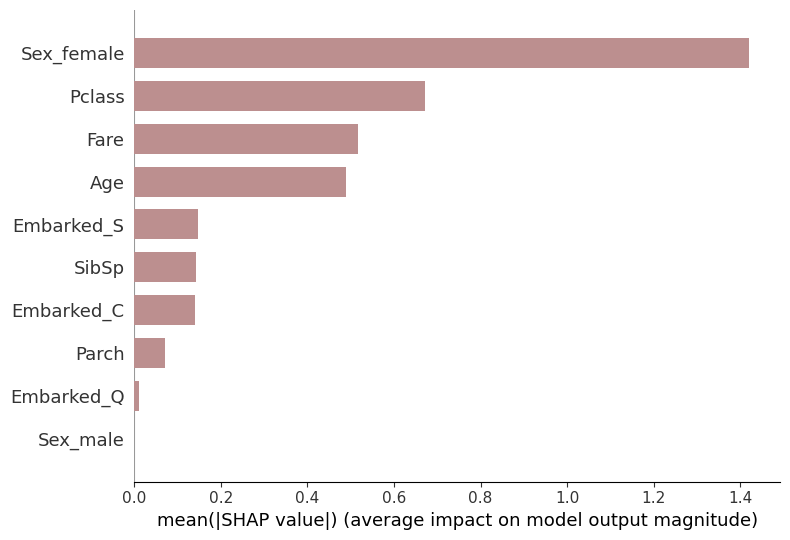

In [39]:
shap.summary_plot(shap_values, X_shap, plot_type="bar", max_display = 10, color = "rosybrown")

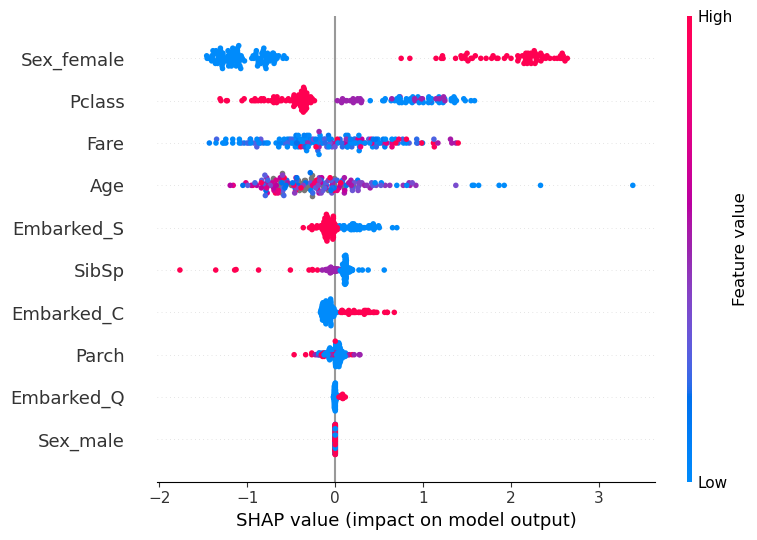

In [40]:
shap.summary_plot(shap_values, X_shap, plot_type="dot")

##### *Análisis:*

- La primera gráfica nos indica el impacto promedio de las variables en cuestión de la clasificación. Como podemos ver, las variables que más impactan en promedio para que la predicción sea "sobrevive" son los siguientes:
    - Sex Female
    - Pclass
    - Fare
    - Age

- Dicho esto las variables que menos influyen para esta predicción son los siguientes:
    - Parch
    - Embarked_Q

- Esto también se puede apreciar en la segunda gráfica, donde también se visualiza el impacto de las variables en el modelo. Con esto, se puede ver que Sex Female y Pclass son variables que impactan positivamente en el modelo, mientras que Embarked_S y SibSp afectan de manera negativa.

### **KMeans y Método del Codo**

##### *Método del codo:*

In [41]:
df.dropna(axis=0, inplace = True)

c:\Users\arant\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\arant\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\arant\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\arant\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

Text(0, 0.5, 'Loss Function')

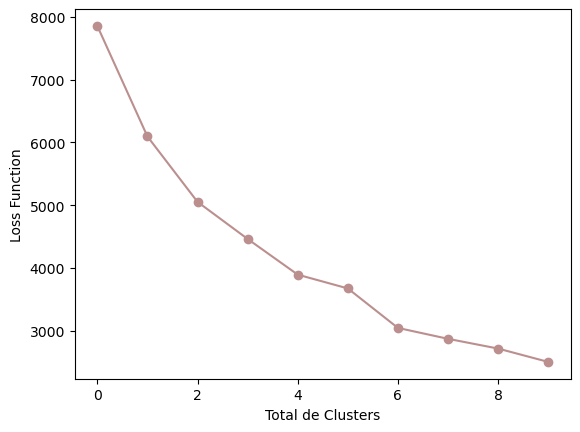

In [42]:
inertias = []

K_range = range(1, 11)
for i in K_range:
    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=i, random_state = 42))
    ])
    pipeline.fit(df)
    inertias.append(pipeline.named_steps['kmeans'].inertia_)

plt.plot(inertias, marker = "o", c = "rosybrown")
plt.xlabel("Total de Clusters")
plt.ylabel("Loss Function")

##### *Análisis:*

- Con el método del codo, podemos ver que el "codo" se encuentra en 4. Esto significa que 4 sería el número óptimo de clusters en el modelo de KMeans. Se eligió este número ya que, a partir de este número, la disminución en la inercia es menos pronunciada, indicándonos que un aumento en la cantidad de clusters no mejoraría de manera significativa el modelo. 

##### *KMeans:*

In [43]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=4))
])

pipeline.fit(df)

c:\Users\arant\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=4))])

In [44]:
df['cluster'] = pipeline.predict(df)

### **Características Generales del Cluster**

##### *Promedio de cada variable por cluster:*

In [46]:
df.groupby('cluster').mean()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
cluster,,,,,,,,,,,
0,0.258929,1.473214,43.802857,0.366071,0.232143,40.016108,0.000000,1.000000,0.0,0.035714,0.964286
1,0.710000,2.195000,27.785000,0.665000,0.770000,37.714563,1.000000,0.000000,0.0,0.060000,0.930000
2,0.607692,1.746154,30.814769,0.423077,0.415385,68.296767,0.469231,0.530769,1.0,0.000000,0.000000
3,0.147059,2.816176,24.765919,0.503676,0.272059,14.222745,0.000000,1.000000,0.0,0.044118,0.955882


##### *Análisis:*

- Como se puede ver en el dataframe anterior, se sacó el promedio de cada variable por cada cluster para poder realizar un análisis más profundo. 
    - Cluster 0: En este cluster se puede analizar que existe una supervivencia algo baja con solo un 25.89%. También, en promedio, este cluster esta entre la primera y segunda pclass. Por otro lado, en el cluster 0 son hombres alrededor de la edad de 43-44, con un fare promedio de alrededor de 40. 

    - Cluster 1: En este cluster son mujeres jóvenes, alrededor de la edad de 27-28, que mayormente estaban en la segunda pclass. Además, este cluster cuenta con una alta posibilidad de supervivencia del 71%. Esto puede ser debido a que, como vimos en nuestro análisis previo, las mujeres tenían mayores probabilidades de sobrevivir en esta situación.

    - Cluster 2: En el cluster 2, existe un porcentaje promedio de supervivencia de 60%, el cual es alto pero no el mejor. Aquí, las personas eran mayormente parte de la primera y segunda pclass y contaban con un fare algo alto de 68.29. En este cluster, aproximadamente el 47% es mujeres y el 53% hombres. Por último, la edad promedio es de 30-31 años. 

    - Cluster 3: Por último, el cluster 3 tiene hombres jóvenes, alrededor de la edad de 24-25 años, que mayormente se encuentran en la segunda o tercera pclass. También, este cluster cuenta con una probabilidad bastante baja de sobrevivencia de solamente el 14.71%, siendo l más baja de todas. Dicho esto, también cuentan con el fare más bajo, siendo de 14.22. 

- Con esto, se refuerza la idea de que ciertas características aumentan la probabilidad de sobrevivir, como por ejemplo: ser mujer, ser de una clase más alta, un fare más elevado, etc. 